In [92]:
import os
import sys
import argparse
import scipy.io
import numpy as np
import librosa
import matplotlib.pyplot as plt

resdir  = '/Users/schwarz/Documents/projects/ABC DJ/src-git/unmixing/results-unmixdb-full/'
mixbase = 'set275mix3-resample-compressor-22'

resname = resdir + mixbase + '.mat'
rmsname = resdir + mixbase + '-rms.mat'

res = scipy.io.loadmat(resname, simplify_cells=True)
rms = scipy.io.loadmat(rmsname, simplify_cells=True)
#print(res)

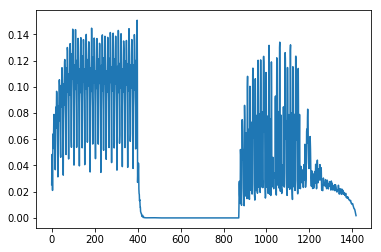

In [93]:
# check loudness of whole mix
plt.plot(rms['rms'])

312 104.0 3
  0 start 103.5 duration   1.2  /Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/mixes/set275mix3-none-bass-00.mp3
  3 start   0.0 duration   2.2  /Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/mixes/set275mix3-none-bass-03.mp3
  3 start 106.6 duration   2.6  /Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/mixes/set275mix3-none-bass-03.mp3


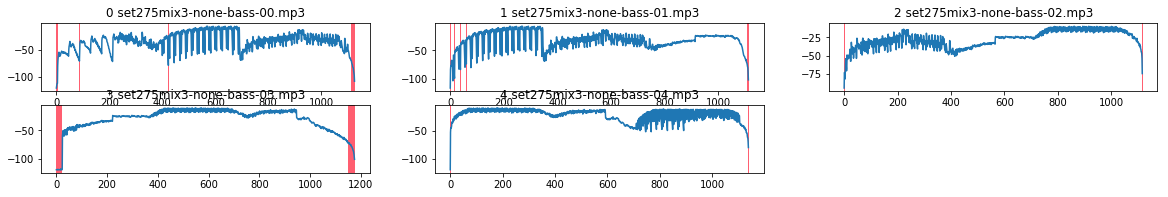

In [12]:
# check for long silent parts
import os
import glob
import soundfile
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def find_runs (cond):
    _, i, c = np.unique(np.r_[[0], cond[:-1] != cond[1:]].cumsum(),
                    return_index = 1,                   
                    return_counts = 1)

    for index, count in zip(i, c):
        if cond[index]:
            yield index, count
        
# refsongdir = '/Users/schwarz/Documents/projects/ABC DJ/data/unmixdb/excerpts/set123/refsongs/'
# refsongdir = '/Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/refsongs/'
refsongdir = '/Volumes/Data/ABC DJ data/unmixdb-v1/mixotic-set275-excerpts/mixes/'

mp3list = glob.glob(refsongdir + '*.mp3')
winsize = 4096
hopsize = 4096

n = 3
m = np.ceil(len(mp3list) / n)
print(len(mp3list), m, n)
plt.figure(figsize=(20, m * 1.5))
plt.tight_layout()

# output dataframes
files  = pd.DataFrame([], columns = ['mixname', 'sr', 'samples'])
chunks = pd.DataFrame([], columns = ['start', 'length', 'duration'])

for i, mp3name in enumerate(mp3list):
    y, sr = soundfile.read(mp3name)

    # to mono
    y = np.sum(y, axis=1)
    #print(y.shape)

    # Extract RMS, convert to dB (clip at -120dB)
    rms = np.squeeze(20 * np.log10(librosa.feature.rms(y=y, frame_length=winsize, hop_length=hopsize) + 1e-6))
    #print(rms.shape, min(rms), max(rms))
    plt.subplot(m, n, i + 1)
    plt.plot(np.squeeze(rms))
    plt.title(f'{i} ' + os.path.basename(mp3name))
    
    # result matrix columns: 
    # silence framestartsamp, silence framenumsamps, silence in seconds
    res = [ ]
    
    # find chunks <-70dB
    for start, count in find_runs(rms < -70):
        sstart = start * hopsize
        sdur   = (count - 1) * hopsize + winsize
        tstart = sstart / sr
        tdur   = sdur / sr
        
        # append to result matrix 
        res.append([ sstart, sdur, tdur ])
        
        if tdur > 1:
            print(f'{i:3} start {tstart: >5.1f} duration {tdur: >5.1f}  {mp3name}')
        plt.axvspan(start, start + count, facecolor=(1, 0.1, 0.2, 0.7))
        
    # convert to dataframes: 
    # file with mixname, sr, duration in samples 
    newf = pd.DataFrame([[mp3name, sr, len(y)]], columns = ['mixname', 'sr', 'samples'])
    newchunks = pd.DataFrame(res, columns = ['start', 'length', 'duration'])

    # append and save
    files  = pd.concat([files,  newf],      ignore_index=True)
    chunks = pd.concat([chunks, newchunks], ignore_index=True)
    
    files.to_csv(path_or_buf='files.csv', sep='\t')
    chunks.to_csv(path_or_buf='chunks.csv', sep='\t')
    files.to_json(path_or_buf='files.json', orient='records')
    chunks.to_json(path_or_buf='chunks.json', orient='records')   

In [89]:
cond = rms < -70
ind = np.argwhere(cond)
dind = ind[1:] - ind[:-1]
arr = np.squeeze(dind)
#print(cond, ind, dind)
#print(arr)

_, i, c = np.unique(np.r_[[0], ~np.isclose(arr[:-1], arr[1:])].cumsum(), 
                    return_index = 1, 
                    return_counts = 1)
for index, count in zip(i, c):
    if count > 1:
        pass#print('start', index, 'len', count, 'duration', ((count - 1) * hopsize + winsize)/ sr)
        
        
cond = np.array([True,True,True,False,False,True,True,False,True])
print(cond)

_, i, c = np.unique(np.r_[[0], cond[:-1] != cond[1:]].cumsum(),
                    return_index = 1,                   
                    return_counts = 1)
for index, count in zip(i, c):
    if cond[index]:
        print(cond[index], 'start', index, 'len', count)
        

[ True  True  True False False  True  True False  True]
True start 0 len 3
True start 5 len 2
True start 8 len 1


(1940480,) /Users/schwarz/Documents/projects/ABC DJ/data/unmixdb/excerpts/set123/refsongs/04_Hiroshi_Oki_-_Unagui_-_Antiritmo011.excerpt40.mp3


Text(0.5, 1.0, '/Users/schwarz/Documents/projects/ABC DJ/data/unmixdb/excerpts/set123/refsongs/04_Hiroshi_Oki_-_Unagui_-_Antiritmo011.excerpt40.mp3')

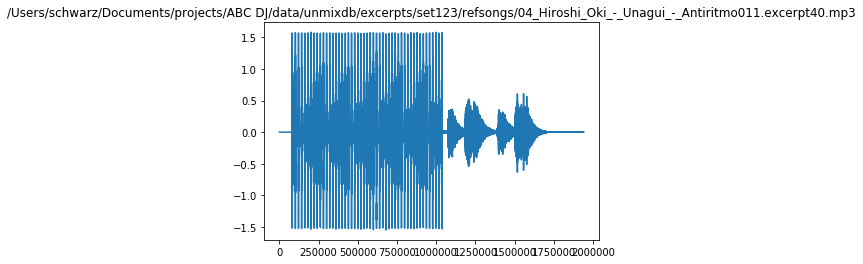

In [12]:
print(y.shape, mp3name)
plt.plot(y)
plt.title(mp3name)

164721757 22050


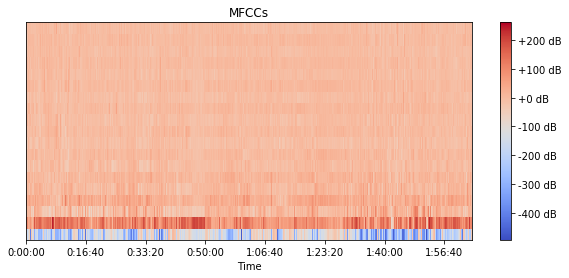

In [7]:
import librosa.display
import matplotlib.pyplot as plt

# Load audio file
audio_file = refsongdir + '01_Sascha_Muller_-_The_Book_Writer_-_Antiritmo002.excerpt40.mp3'
#audio_file = refsongdir + '02_Katsuyuki_Taguchi_-_Indigoblue_-_Antiritmo028.excerpt40.mp3'
audio_file = '/Users/schwarz/Music/radio/RL-2024-05-02-22-00.mp3'
y, sr = librosa.load(audio_file)
print(len(y), sr)

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr)

# Display MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs')
plt.show()

In [66]:
rms < -70

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,